### Detailed Agentic RAG Implementation

#### Mutiple TOOLs RAG, Using create_agent with context_schema and response_format

In [1]:
import os
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

from langchain.chat_models import init_chat_model
from langchain.tools import tool


d:\RAGs In Depth\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#langchain text file data ingestion and preparing retriever tool

print("Data Ingestion:")
langchain_docs = TextLoader("langchain_notes.txt", encoding="utf-8").load()
print(f"Number of langchain documents: {len(langchain_docs)}")
langchain_chunks = RecursiveCharacterTextSplitter(
    chunk_size=300,
    chunk_overlap=50
).split_documents(langchain_docs)
print(f"Number of langchain chunks: {len(langchain_chunks)}\n")
print("Vectorstore and Retriver:")
langchain_retriever = FAISS.from_documents(
    documents=langchain_chunks,
    embedding = HuggingFaceEmbeddings(model="sentence-transformers/all-MiniLM-L6-v2")
).as_retriever()
print("Langchain Retriver is Ready")

Data Ingestion:
Number of langchain documents: 1
Number of langchain chunks: 16

Vectorstore and Retriver:
Langchain Retriver is Ready


In [3]:
#langgraph text file data ingestion and preparing retriever tool

print("Data Ingestion:")
langgraph_docs = TextLoader("langgraph_notes.txt", encoding="utf-8").load()
print(f"Number of langgraph documents: {len(langchain_docs)}")
langgraph_chunks = RecursiveCharacterTextSplitter(
    chunk_size=300,
    chunk_overlap=50
).split_documents(langgraph_docs)
print(f"Number of langchain chunks: {len(langgraph_chunks)}\n")
print("Vectorstore and Retriver:")
langgraph_retriever = FAISS.from_documents(
    documents=langgraph_chunks,
    embedding = HuggingFaceEmbeddings(model="sentence-transformers/all-MiniLM-L6-v2")
).as_retriever()
print("langgraph Retriver is Ready")

Data Ingestion:
Number of langgraph documents: 1
Number of langchain chunks: 17

Vectorstore and Retriver:
langgraph Retriver is Ready


In [4]:
#defining a base model

model = init_chat_model(model="groq:llama-3.1-8b-instant")
model

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000001DC50598250>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001DC4EDFEB10>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [5]:
#tools
from langchain.tools import tool

@tool
def langchain_retrieve_docs(query:str):
    """this function is used to retrieve relevant docs for given user question, if question is related to langchain"""
    relevant_docs = langchain_retriever.invoke(query)
    return relevant_docs

@tool
def langgraph_retrieve_docs(query:str):
    """this function is used to retrieve relevant docs for given user question, if question is related to langgraph"""
    relevant_docs = langgraph_retriever.invoke(query)
    return relevant_docs


tools = [langchain_retrieve_docs, langgraph_retrieve_docs]


In [6]:
#agent
from langchain.agents import create_agent
agent= create_agent(model=model, tools=[langchain_retrieve_docs], debug=True)

In [7]:
#defining state schema
from typing_extensions import TypedDict
from pydantic import BaseModel
from typing import List, Literal
from langchain_core.documents import Document

class State(BaseModel):
    question: str
    answer: str = ""
    grade: Literal['yes', 'no'] = "no"
    final_answer: str = ""

In [8]:
#defining nodes
from langchain.agents.structured_output import ToolStrategy
#score class schema

class Score(TypedDict):
    score: Literal['yes', 'no']

#generate answer node

def generate_answer(state:State)->State:
    """this function generates answer from the agent either by calling available tools 
    or giving answer directly without tool calling based on user question """

    res = agent.invoke({"messages":[{"role":"user", "content": state.question}]})
    return state.model_copy(update={'answer': res['messages'][-1].content})

# grader node

def grader(state:State)->State:
    """This function is used to grade the answer generated from the agent"""
    grade_model = create_agent(model=model,
                               system_prompt='grade whether given question and generated answer is relevant or not',
                               response_format=ToolStrategy(Score),
                               context_schema=State)
    response = grade_model.invoke({"messages":[{"role":"user", "content":state.question}]}, context={"question":state.question, 
                                "answer":state.answer})
    return state.model_copy(update={'grade': response['structured_response']['score']})


def final_answer(state:State)->State:
    "this function stores final_answer as current answer value"
    return state.model_copy(update={"final_answer": state.answer})


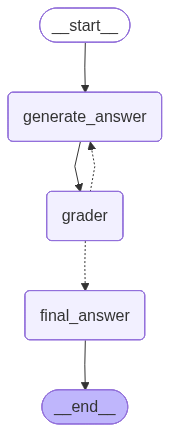

In [9]:
#defining graph workflow
from langgraph.graph import StateGraph, START, END

graph = StateGraph(State)

graph.add_node("generate_answer", generate_answer)
graph.add_node("grader", grader)
graph.add_node("final_answer", final_answer)

graph.add_edge(START, "generate_answer")
graph.add_edge("generate_answer", "grader")
graph.add_conditional_edges("grader", lambda s: "generate_answer" if s.grade =="no" else "final_answer",
                            {"generate_answer":"generate_answer", "final_answer":"final_answer"})
graph.add_edge("final_answer", END)

graph_builder = graph.compile()
graph_builder

In [12]:
query ="give main components in langchain"
state=State(question=query)
result = graph_builder.invoke({"question":state.question})
result

[values] {'messages': [HumanMessage(content='give main components in langchain', additional_kwargs={}, response_metadata={}, id='aa11426d-c4d5-472d-a66e-978c00e989dd')]}
[updates] {'model': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '14g535cmx', 'function': {'arguments': '{"query":"main components in langchain"}', 'name': 'langchain_retrieve_docs'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 252, 'total_tokens': 274, 'completion_time': 0.026648577, 'completion_tokens_details': None, 'prompt_time': 0.019351785, 'prompt_tokens_details': None, 'queue_time': 0.066306365, 'total_time': 0.046000362}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b61c5-aa82-7450-a8f4-d4ba3ea1f7d4-0', tool_calls=[{'name': 'langchain_retrieve_docs', 'args': {'query': 'main 

{'question': 'give main components in langchain',
 'answer': 'The main components of langchain include:\n\n1. Modular Workflows: LangChain offers modular workflows, making it easy to reuse and adapt components across different applications.\n2. Prompt Management Tools: LangChain provides prompt management tools, which help developers engineer effective prompts and handle context efficiently.\n3. Integration: LangChain provides ease of integration—developers can connect LLMs like GPT-4 to external data sources, APIs, and computational resources.\n4. Long-Running Workloads: LangChain enables long-running workloads with human oversight, making it suitable for mission-critical applications.\n5. Standard Interface: LangChain provides a standard interface for integrations, allowing developers to build applications that can query databases, call APIs, and process information in a modular way.',
 'grade': 'yes',
 'final_answer': 'The main components of langchain include:\n\n1. Modular Workflow